In [1]:
# Nathan Snyder
# COVID-19 Forecaster
# Predicts the number of future COVID-19 using an LSTM neural network and polynomial fits using the Gauss-Newton algorithm

from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import numpy as np
from numpy.linalg import pinv
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from typing import Callable
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Import data - only the data for the world as a whole
data = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv", usecols=["World"])
x = np.arange(0, data.shape[0])
y = data["World"].tolist()

In [3]:
# Use a long short-term memory neural network to fit the data and predict future cases
class LSTMNeuralNet:
    def __init__(self, 
                 x: np.ndarray,
                 y: np.ndarray):
        self.x = x
        self.y = y
        self.prediction = 0
        self.x_train = []
        self.y_train = []
        self.model = 0
        self.scaler = 0

    # prepare the data and make training sets for the model
    # only train the model with a subset of the data
    def prepDataForModel(self):
        # retrieve the data
        world_data = data.filter(["World"])
        world_dataset = world_data.values
        training_data_len = len(world_dataset) - 1

        # scale the data for the model
        self.scaler = MinMaxScaler(feature_range = (0, 1)) 
        world_scaled_data = self.scaler.fit_transform(world_dataset)
        train_data = world_scaled_data[0:training_data_len, : ]

        # add data into the x- and y- training sets
        for i in range(60, len(train_data)):
            self.x_train.append(train_data[i - 60 : i, 0])
            self.y_train.append(train_data[i, 0])
  
        # reshape the x- and y- training sets
        self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)
        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1],1))

    # set up the model
    def setUpModel(self):
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(self.x_train.shape[1], 1)))
        self.model.add(LSTM(units=50, return_sequences=False))
        self.model.add(Dense(units=25))
        self.model.add(Dense(units=1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    # test the model with the rest of the data that was not used for testing
    def testModel(self):
        # create the testing sets
        world_dataset = data.filter(["World"]).values
        test_data = self.scaler.fit_transform(world_dataset)[len(world_dataset) - 61 : , : ]
        self.x_test = []
        self.y_test = world_dataset[len(world_dataset) - 1 : , : ]
        for i in range(60, len(test_data)):
            self.x_test.append(test_data[i-60:i,0])

        # reshape the testing sets
        self.x_test = np.array(self.x_test)
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1],1))

    # use the LSTM neural net to get tomorrow's case number
    def getTomorrowsCaseNumber(self):
        # prepare the training data for the model
        self.prepDataForModel()

        # set up the model and train it with the training data
        self.setUpModel()
        self.model.fit(self.x_train, self.y_train, batch_size=1, epochs=1)

        # test the model and get a prediction for tomorrow's case number
        self.testModel()
        self.prediction = self.scaler.inverse_transform(self.model.predict(self.x_test))[0][0]

In [4]:
# Fit functions to the data using the Gauss-Newton algorithm
class GaussNewtonAlgo:
    def __init__(self,
                 degree: int,
                 fit_function: Callable,
                 max_iter: int = 1000,
                 tolerance_difference: float = 10 ** (-16),
                 tolerance: float = 10 ** (-9)):
        self.degree = degree
        self.fit_function = fit_function
        self.max_iter = max_iter
        self.tolerance_difference = tolerance_difference
        self.tolerance = tolerance
        self.x = None
        self.y = None
        self.coefficients = None
        self.init_guess = None

    # calculate the fit by adjusting coefficients and comparing the fit to the data
    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            init_guess: np.ndarray) -> np.ndarray:
        self.x = x
        self.y = y
        self.init_guess = init_guess
        self.coefficients = self.init_guess
        rmse_prev = np.inf

        for k in range(self.max_iter):
            # calculate the residual and jacobian and modify the coefficients
            residual = self.get_residual()
            jacobian = self._calculate_jacobian(self.coefficients, step=10 ** (-6))
            self.coefficients -= (pinv(jacobian.T @ jacobian) @ jacobian.T) @ residual
            
            # check if the coefficients are close to accurately portraying the data
            # repeat the process if they aren't
            rmse = np.sqrt(np.sum(residual ** 2))
            diff = np.abs(rmse_prev - rmse)
            if (diff < self.tolerance_difference) or (rmse < self.tolerance):
                return self.coefficients
            rmse_prev = rmse
        
        return self.coefficients

    # get an estimate of the next value by applying the fit function
    def get_estimate(self) -> np.ndarray:
        return self.fit_function(self.degree, self.x, self.coefficients)

    # return the residual by calling the _calculate_resideual function, using the coefficients
    def get_residual(self) -> np.ndarray:
        return self._calculate_residual(self.coefficients)

    # calculate the residual by applying the fit function and getting the difference
    def _calculate_residual(self, coefficients: np.ndarray) -> np.ndarray:
        y_fit = self.fit_function(self.degree, self.x, coefficients)
        return y_fit - self.y

    # calculate the jacobian
    def _calculate_jacobian(self,
                            x0: np.ndarray,
                            step: float = 10 ** (-6)) -> np.ndarray:
        y0 = self._calculate_residual(x0)

        jacobian = []
        for i, parameter in enumerate(x0):
            x = x0.copy()
            x[i] += step
            y = self._calculate_residual(x)
            derivative = (y - y0) / step
            jacobian.append(derivative)
        jacobian = np.array(jacobian).T

        return jacobian

In [5]:
# Polynomial function that can be used to fit the data
COEFFICIENTS = [1, 1, 1, 1]
def func(degree, x, coeff):
    returnvar = 0
    for i in range(degree + 1):
        returnvar += coeff[i] * (x ** i)
    return returnvar

# Solver for a cubic polynomial regression
solver1 = GaussNewtonAlgo(degree=3, fit_function=func)
init_guess1 = 1000000 * np.random.random(len(COEFFICIENTS))
solver1.fit(x, y, init_guess1)
fit1 = solver1.get_estimate()

# Solver for a quadratic polynomial regression
solver2 = GaussNewtonAlgo(degree=2, fit_function=func)
init_guess2 = 1000000 * np.random.random(len(COEFFICIENTS))
solver2.fit(x, y, init_guess2)
fit2 = solver2.get_estimate()

In [6]:
# Set up the neural network and get tomorrow's case number
lnn = LSTMNeuralNet(x, y)
lnn.getTomorrowsCaseNumber()

274/274 [==============================] - 9s 23ms/step - loss: 0.0082


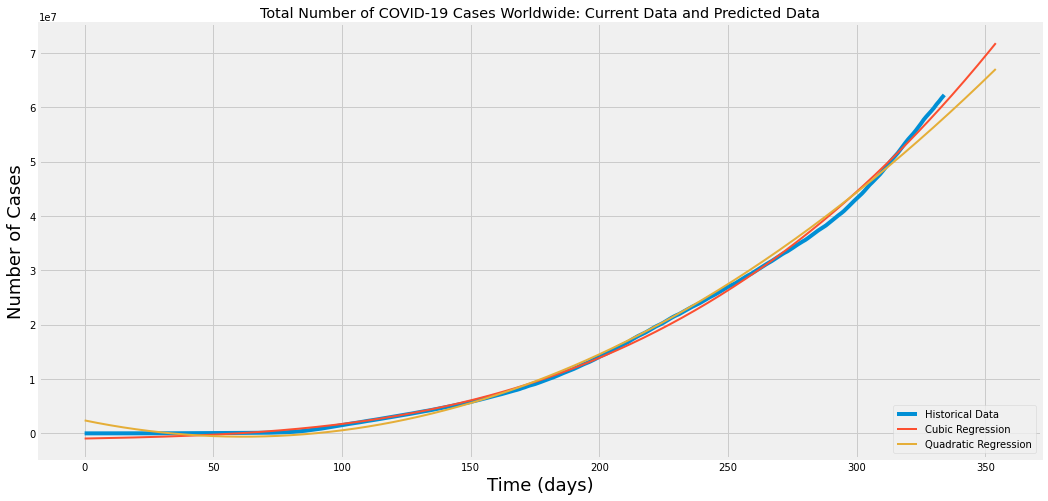

In [7]:
# Create a plot of the data and the calculated regression fits
plt.figure(figsize=(16,8))
plt.title('Total Number of COVID-19 Cases Worldwide: Current Data and Predicted Data')
plt.xlabel("Time (days)", fontsize=18)
plt.ylabel("Number of Cases", fontsize=18)
plt.plot(x, y, linewidth=4)
xplus20 = np.arange(0, data.shape[0] + 20)
plt.plot(xplus20, func(3, xplus20, solver1.coefficients), linewidth=2)
plt.plot(xplus20, func(2, xplus20, solver2.coefficients), linewidth=2)
plt.legend(['Historical Data', 'Cubic Regression', 'Quadratic Regression'], loc='lower right')
plt.show()

In [8]:
# Print out the values estimated by the neural network
print("There were " + str(y[-2]) + " cases today.")
print("The LSTM neural network predicts that there will be " + str(round(lnn.prediction)) + " cases tomorrow.")
if (lnn.prediction > y[-2]):
  # Predicted an increase
  print("This is a " + str(round(100 * ((lnn.prediction / y[-2]) - 1), 3)) + "% increase.")
else:
  # Predicted a decrease
  print("This is a " + str(-1 * round(100 * ((lnn.prediction / y[-2]) - 1), 3)) + "% decrease.")

There were 61718735 cases today.
The LSTM neural network predicts that there will be 62052212 cases tomorrow.
This is a 0.54% increase.
